In [1]:
!pip install pennylane --upgrade
!pip install pennylane-cirq
# Select one or more ML libraries above to install them to work with PennyLane.
!pip install "tensorflow>=1.13.2"

     |████████████████████████████████| 409kB 9.3MB/s 
  Created wheel for pennylane: filename=PennyLane-0.14.1-cp37-none-any.whl size=481980 sha256=1a78f1da93dc5db17ed48bcf3d49f05e5cf6f30811ae66ccb808fbb12037d0ca
  Stored in directory: /root/.cache/pip/wheels/6e/a9/c9/04941d6dd58b3c111cbd1389bf63ba1b23362c137359af4626
Successfully built pennylane
     |████████████████████████████████| 1.8MB 9.1MB/s 
     |████████████████████████████████| 1.3MB 37.8MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [2]:
import numpy as np
import tensorflow as tf
import pennylane as qml
qml.about()

Name: PennyLane
Version: 0.14.1
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: toml, scipy, networkx, numpy, appdirs, autograd, semantic-version
Required-by: PennyLane-Cirq
Platform info:           Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.7.10
Numpy version:           1.19.5
Scipy version:           1.4.1
Installed devices:


In [3]:
dev = qml.device('cirq.simulator', wires=3)

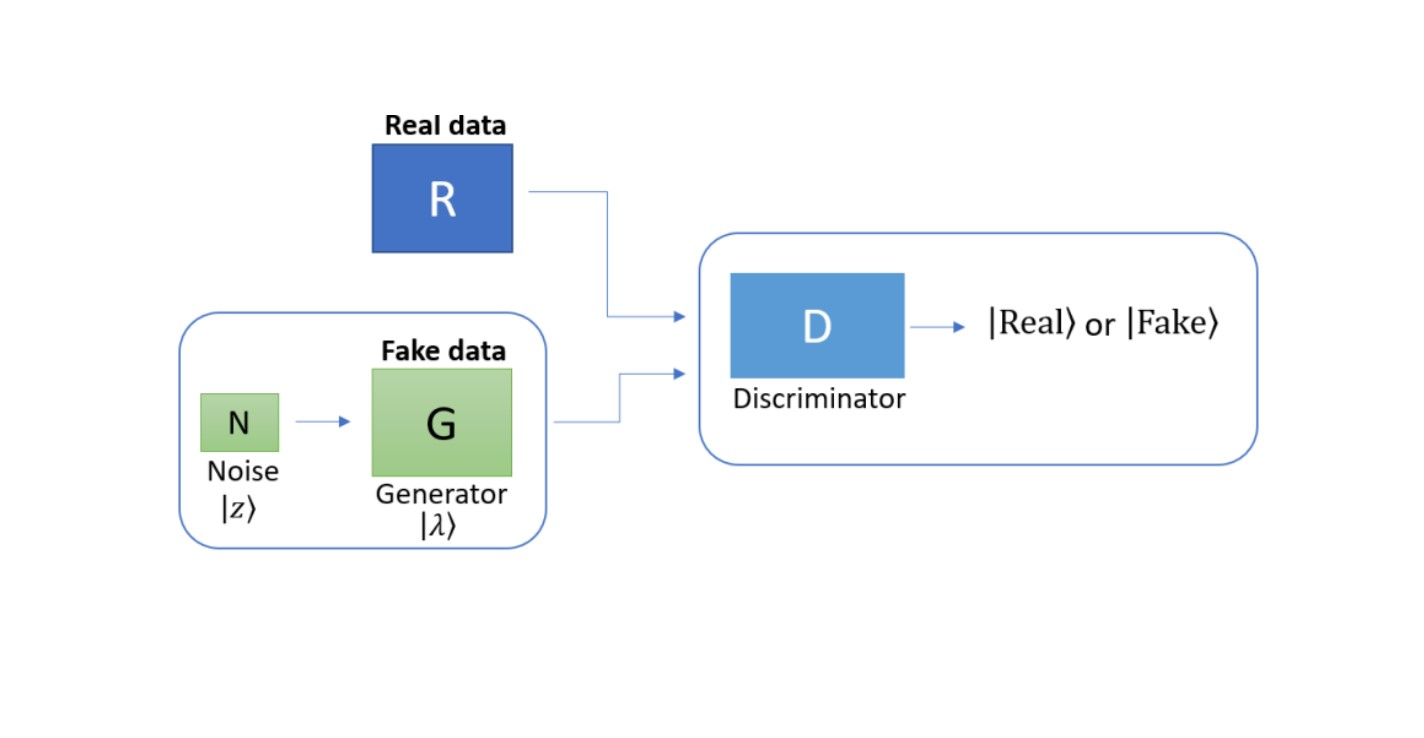

In [4]:
def real(angles, **kwargs):
  qml.Hadamard(wires=0)
  qml.Rot(*angles, wires=0)


def generator(w, **kwargs):
  qml.Hadamard(wires=0)
  qml.RX(w[0], wires=0)
  qml.RX(w[1], wires=1)
  qml.RY(w[2], wires=0)
  qml.RY(w[3], wires=1)
  qml.RZ(w[4], wires=0)
  qml.RZ(w[5], wires=1)
  qml.CNOT(wires=[0,1])
  qml.RX(w[6], wires=0)
  qml.RY(w[7], wires=0)
  qml.RZ(w[8], wires=0)


def discriminator(w):
  qml.Hadamard(wires=0)
  qml.RX(w[0], wires=0)
  qml.RX(w[1], wires=2)
  qml.RY(w[2], wires=0)
  qml.RY(w[3], wires=2)
  qml.RZ(w[4], wires=0)
  qml.RZ(w[5], wires=2)
  qml.CNOT(wires=[0,2])
  qml.RX(w[6], wires=2)
  qml.RY(w[7], wires=2)
  qml.RZ(w[8], wires=2)

# Quantum nodes with Tensorflow
@qml.qnode(dev, interface="tf")
def real_disc_circuit(phi, theta, omega, disc_weights):
  real([phi, theta, omega])
  discriminator(disc_weights)
  return qml.expval(qml.PauliZ(2))

@qml.qnode(dev, interface="tf")
def gen_disc_circuit(gen_weights, disc_weights):
  generator(gen_weights)
  discriminator(disc_weights)
  return qml.expval(qml.PauliZ(2))

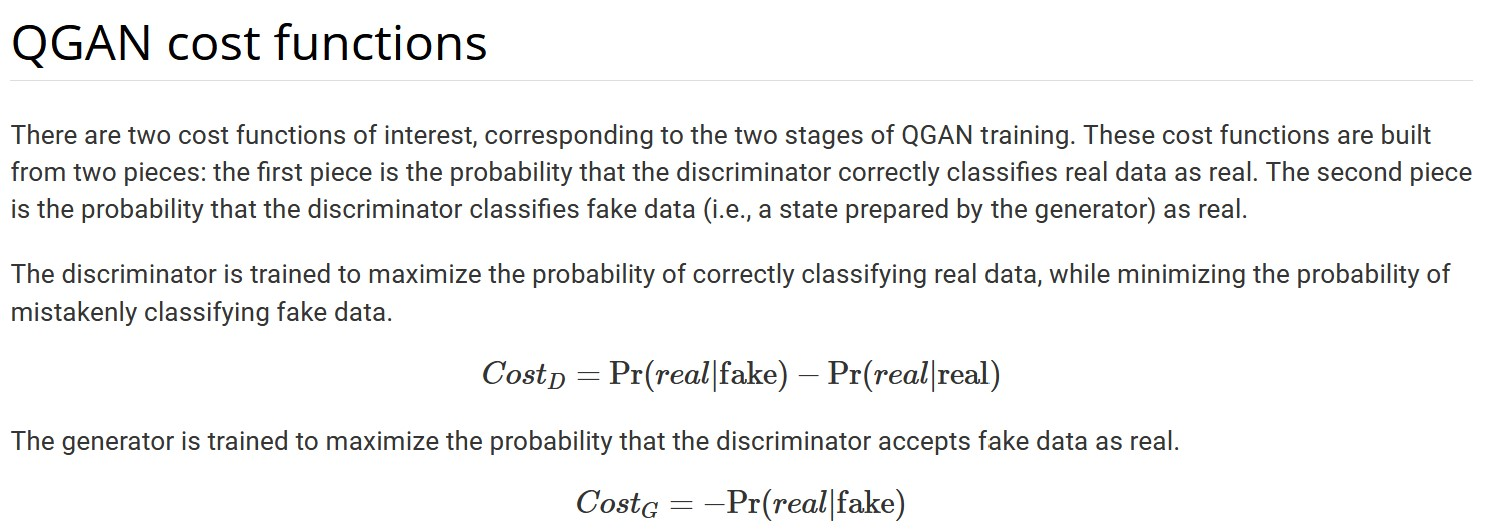

In [5]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

In [6]:
"""Training QuGAN"""

phi = np.pi/6
theta = np.pi/2
omega = np.pi/7
np.random.seed(0)
eps = 1e-2

init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))

init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

In [7]:
opt = tf.keras.optimizers.SGD(0.4)
cost = lambda: disc_cost(disc_weights)

In [8]:
for step in range(50):
    opt.minimize(cost, disc_weights)
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.7/dist-packages/pennylane/tape/tapes/jacobian_tape.py:585: ComplexWarning: Casting complex values to real discards the imaginary part
  jac[:, i] = g


Step 0: cost = -0.05727684497833252
Step 5: cost = -0.26348113268613815
Step 10: cost = -0.4273916110396385
Step 15: cost = -0.47261594980955124
Step 20: cost = -0.48406897485256195
Step 25: cost = -0.48946401476860046
Step 30: cost = -0.4928189888596535
Step 35: cost = -0.4949494078755379
Step 40: cost = -0.49627023935317993
Step 45: cost = -0.4970719963312149


In [9]:
print("Prob(real classified as real): ", prob_real_true(disc_weights).numpy())


Prob(real classified as real):  0.998587042093277


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


In [10]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.5011128261685371


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


In [11]:
cost = lambda: gen_cost(gen_weights)

for step in range(50):
    opt.minimize(cost, gen_weights)
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.7/dist-packages/pennylane/tape/tapes/jacobian_tape.py:585: ComplexWarning: Casting complex values to real discards the imaginary part
  jac[:, i] = g


Step 0: cost = -0.5833386331796646
Step 5: cost = -0.8915729522705078
Step 10: cost = -0.9784243106842041
Step 15: cost = -0.9946483373641968
Step 20: cost = -0.9984995424747467
Step 25: cost = -0.9995636343955994
Step 30: cost = -0.999871701002121
Step 35: cost = -0.9999619424343109
Step 40: cost = -0.9999886155128479
Step 45: cost = -0.9999965131282806


In [12]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.9999986290931702


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


In [13]:
print("Discriminator cost: ", disc_cost(disc_weights).numpy())

Discriminator cost:  0.0014115869998931885


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


In [14]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_generator = qml.map(generator, obs, dev, interface="tf")

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights)))

Real Bloch vector: [-0.86602521 -0.21694188 -0.86602527]
Generator Bloch vector: [-0.8624441  -0.28404635 -0.8624441 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
